In [1]:
from pathlib import Path

In [2]:
import sys
import warnings

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

# Load the GMAT Python API
sys.path.append(f'{Path.home()}/Downloads/GMAT-src-R2020a/GMAT-R2020a/GMAT-R2020a-Linux-x64/api/')
from load_gmat import *

from skyfield.api import EarthSatellite, load
from sgp4.api import Satrec, WGS72
from sgp4.model import wgs72, wgs84
from sgp4.conveniences import jday_datetime, UTC, sat_epoch_datetime, dump_satrec

import pandas as pd

import coord_skyfield
from coord_skyfield import ITRF2TEME, TEME2ITRF

from tlefit_equinoctial_eph_fd import *


## Mock up an example OPM
This block of code will take an existing satellite from a TLE, propagate it 100 minutes from its epoch, and print the osculating orbit state vector (with some random noise added) in the ITRF (ECEF) coordinate frame. We also print the epoch for that state. If you already have an OPM from your launch provider, you can skip this step.

In [3]:
# We'll use an existing satellite and fudge it a bit to fake a pre or post-launch OPM from a launch provider

ts = load.timescale()

line1 = '1 40019U 14033K   21064.48089419  .00000027  00000-0  13123-4 0  9994'
line2 = '2 40019  97.7274 245.3630 0083155 314.3836  45.0579 14.67086574359033'
satellite = EarthSatellite(line1, line2, 'APRIZESAT 10', ts)

# Propagate TLE 100 minutes from epoch
err, r, v = satellite.model.sgp4_tsince(100) # Propagate 100 minutes from epoch, just to make it spicy

np.random.seed(42)

# Add some random offsets
r += np.random.randn(3) * 10 / 1000
v += np.random.randn(3) * 0.001 / 1000

# Update the epoch
epoch_dt = sat_epoch_datetime(satellite.model) + dt.timedelta(minutes=100)
epoch = epoch_dt.strftime('%d %b %Y %H:%M:%S.%f')[:-3]

# Convert the new state vector from TEME (SGP4) to ITRF (ECEF) coordinate frame
r, v = TEME2ITRF([epoch_dt], [(r, v)])[0]

In [4]:
print(epoch)
print(r, v)

05 Mar 2021 13:12:29.258
[-3173.91430404 -6203.94723041   802.14005485] [-0.99114021  1.42336564  7.44539408]


## OPM Input
If you have a pre or post-launch OPM from your launch provider, enter the epoch and state vector in the cell below. This script expects a UTC timestamp and a state vector in the rotating ITRF (ECEF) coordinate frame. This is usually what is provided, but if you have something else, you can usually do some extra work to get to ECEF.

If you don't have an OPM or you're just experimenting, use the dummy OPM data we generated above.

Since we're using python lists, you can enter multiple epochs and state vectors to represent multiple satellites.

In [5]:
epochs = ["05 Mar 2021 13:12:29.258"]

states = [([-3173.91430404, -6203.94723041, 802.14005485], [-0.99114021, 1.42336564, 7.44539408])]

Loop through OPM satellites and use GMAT to propagate the spacecraft forward by 3 days using a high precision orbit propagator (Special Perturbations) to obtain an ephemeris we can later use to  fit a TLE

In [6]:
for idx, (t, state) in enumerate(zip(epochs, states)):
    print(idx)

    r, v = state[0], state[1]

    gmat.LoadScript("gmat/prelaunch_opm.script")

    sat = gmat.GetObject("Sat")
    sat.SetField("Epoch", t)
    sat.SetField("X", r[0])
    sat.SetField("Y", r[1])
    sat.SetField("Z", r[2])
    sat.SetField("VX", v[0])
    sat.SetField("VY", v[1])
    sat.SetField("VZ", v[2])

    # You will want to set appropriate values for drag and mass specific to your staellites
    sat.SetField("DragArea", 0.087) # m^2
    sat.SetField("DryMass", 15) # kg
    
    eph = gmat.GetObject("EphemerisFile1")
    eph.SetField("Filename", f'/home/dan/GIT/tle-tailor/output/EphemerisFile_Sat{idx}.e')

    gmat.RunScript()

0


Read the GMAT ephemeris files and save them as feather files.

In [7]:
for idx, t in enumerate(epochs):

    df = pd.read_fwf(f'{Path.home()}/GIT/tle-tailor/output/EphemerisFile_Sat{idx}.e', widths=(21, 24, 24, 24, 24, 24, 24), names=('time', 'x', 'y', 'z', 'xdot', 'ydot', 'zdot'), skiprows=15, skipfooter=4)
    df['timestamp'] = pd.Timestamp(epochs[idx], tz='UTC') + pd.to_timedelta(df.time, unit='s')
    df.to_feather(f'sat{idx}.fth')


Loop over the satellites' ephemeris we generated from GMAT and use it to fit a TLE.

In [8]:
for idx in range(len(states)):

    df = pd.read_feather(f'sat{idx}.fth')

    # Convert state vectors from ECEF to TEME
    t = df.timestamp
    ephemeris = [((row['x'], row['y'], row['z']), (row['xdot'], row['ydot'], row['zdot'])) for idx, row in df.iterrows()]

    ephemeris_teme = ITRF2TEME(t, ephemeris)
    ephemeris = ephemeris_teme
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        t = np.array([_t.to_pydatetime() for _t in t])

    # Run the fitter
    last_obs = 4320
    obs_stride = 1
    epoch_obs = 0
    lamda = 1e-3 * 0 + 1 # Interesting.The smaller number works, but diverges. This is better
    rms_epsilon = 0.002
    iterations, solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = \
    test_tle_fit_normalized_equinoctial(t, ephemeris, central_diff=True, last_obs=last_obs, obs_stride=obs_stride, epoch_obs=epoch_obs, lamda=lamda, rms_epsilon=rms_epsilon, debug=False)

    # Optionally thin the observations
    tt = t[::obs_stride]
    tephemeris = ephemeris[::obs_stride]

    if last_obs:
        tt = tt[:last_obs]
        tephemeris = tephemeris[:last_obs]

    print(f'Epoch: {tt[epoch_obs]}\n')

    print('\n'.join(exporter.export_tle(solve_sat.model)))
    print('\n')

Epoch: 2021-03-05 13:17:31.498125+00:00

1 99999U 1800100  21064.55383678  .00000000  00000-0  12440-3 0  9997
2 99999  97.7289 245.4295 0082987 313.9440  70.5114 14.67088177    16




## Find the distance to TLEs with the same launch and proximate epoch

Note: It only makes sense to do this if your satellite has already launched and 18 SDS is tracking objects from your launch. Or you can use it with the example satellite as well.

In [9]:
import datetime as dt

import json

from sgp4.conveniences import sat_epoch_datetime, jday_datetime

from spacetrack import SpaceTrackClient
import spacetrack.operators as op

st = SpaceTrackClient(os.environ['SPACETRACK_USER'], os.environ['SPACETRACK_PWD'])

Search for objects in the same launch group. For your own satellite, you'll want to update the `object_id_like` variable to match the launch year and launch number portions of your launch's international designator. In the example, the satellite was part of the 33rd launch in 2014.

In [10]:
object_id_like = "2014-033~~" 
launch_objects = json.loads(st.gp(object_id=op.like(object_id_like), orderby='TLE_LINE1', format='json'))

In [11]:
tles = []

sat_ids = [sat['NORAD_CAT_ID'] for sat in launch_objects]

Get the General Perturbations (GP) aka TLEs for objects in the launch group and centered in time around the epoch.

In [12]:
sat_gps = json.loads(st.gp_history(norad_cat_id=','.join(sat_ids),  epoch=op.inclusive_range((sat_epoch_datetime(solve_sat.model) - dt.timedelta(days=1)).date(), (sat_epoch_datetime(solve_sat.model) + dt.timedelta(days=+2)).date()), orderby='TLE_LINE1', format='json'))

In [13]:
def solution_residuals(t, solve_sat, comp_sat):
    
    bs = []
    
    offset_idxs = range(len(t))
    
    for offset_idx in offset_idxs:

        # Obs - Nom
        jd, jdf = jday_datetime(t[offset_idx])
        b = np.ravel(np.array(np.array(solve_sat.sgp4(jd, jdf)[1:] - np.array(comp_sat.sgp4(jd, jdf)[1:]))))[:3]

        bs.append(b.T @ b)
        
    return np.array(bs)

Loop over objects in the launch group and calculate the residuals between the SpaceTrack object and the TLE we solved for

In [14]:
candidates = []

for sat in sat_gps:
    candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)

    res = solution_residuals(t, solve_sat.model, candidate_sat.model)
    res_epoch = np.sqrt(res[epoch_obs])
    res = np.sqrt(np.mean(res))

    candidates.append((sat["NORAD_CAT_ID"], sat["OBJECT_ID"], sat["EPOCH"], sat["TLE_LINE0"], sat["TLE_LINE1"], sat["TLE_LINE2"], res, res_epoch))

In [15]:
df_candidates = pd.DataFrame(candidates, columns=['norad_cat_id', 'object_id', 'epoch', 'tle_line0', 'tle_line1', 'tle_line2', 'residual', 'residual_epoch'])

If we're lucky, when we sort the results by RMS residual, the top (mimimum residual) will correspond to our object. Ideally, the next closest object will have a much larger residual. Note you will likely have several TLEs for each object because we search over several days.

In [16]:
df_candidates.sort_values('residual').head(20)

,norad_cat_id,object_id,epoch,tle_line0,tle_line1,tle_line2,residual,residual_epoch
105,40019,2014-033K,2021-03-04T10:59:18.094848,0 APRIZESAT 10,1 40019U 14033K 21063.45784832 .00000031 0...,2 40019 97.7273 244.3980 0083219 317.6953 41...,3.590778,0.475737
106,40019,2014-033K,2021-03-04T10:59:18.094848,0 APRIZESAT 10,1 40019U 14033K 21063.45784832 .00000031 0...,2 40019 97.7273 244.3980 0083219 317.6953 41...,3.590778,0.475737
104,40019,2014-033K,2021-03-04T01:10:01.639776,0 APRIZESAT 10,1 40019U 14033K 21063.04863009 .00000026 0...,2 40019 97.7273 244.0120 0083241 319.0193 40...,3.629871,0.487912
107,40019,2014-033K,2021-03-04T17:32:09.071520,0 APRIZESAT 10,1 40019U 14033K 21063.73066055 .00000024 0...,2 40019 97.7274 244.6553 0083197 316.8128 42...,3.732586,0.433976
108,40019,2014-033K,2021-03-04T17:32:09.071520,0 APRIZESAT 10,1 40019U 14033K 21063.73066055 .00000024 0...,2 40019 97.7274 244.6553 0083197 316.8128 42...,3.732586,0.433976
116,40019,2014-033K,2021-03-06T21:54:56.929824,0 APRIZESAT 10,1 40019U 14033K 21065.91315891 .00000034 0...,2 40019 97.7276 246.7139 0083072 309.7504 49...,3.741052,0.396077
117,40019,2014-033K,2021-03-06T23:33:09.677664,0 APRIZESAT 10,1 40019U 14033K 21065.98136201 .00000035 0...,2 40019 97.7276 246.7783 0083069 309.5300 49...,3.742305,0.404213
110,40019,2014-033K,2021-03-05T11:32:29.258016,0 APRIZESAT 10,1 40019U 14033K 21064.48089419 .00000027 0...,2 40019 97.7274 245.3630 0083155 314.3836 45...,3.742855,0.416303
109,40019,2014-033K,2021-03-05T00:05:00.048192,0 APRIZESAT 10,1 40019U 14033K 21064.00347278 .00000025 0...,2 40019 97.7274 244.9126 0083182 315.9314 43...,3.743016,0.420459
112,40019,2014-033K,2021-03-05T18:05:20.238144,0 APRIZESAT 10,1 40019U 14033K 21064.75370646 .00000028 0...,2 40019 97.7275 245.6203 0083134 313.5003 45...,3.743527,0.405091


In [17]:
obj_ix = df_candidates.sort_values('residual').index[0]
obj_ix

105

In [18]:
print(exporter.export_tle(solve_sat.model))
print((sat['TLE_LINE1'], sat['TLE_LINE2']))

('1 99999U 1800100  21064.55383678  .00000000  00000-0  12440-3 0  9997', '2 99999  97.7289 245.4295 0082987 313.9440  70.5114 14.67088177    16')
('1 40049U 14033AR  21065.75113626  .00000369  00000-0  45874-4 0  9993', '2 40049  97.9297 354.7348 0013281 153.7451 206.4441 14.88346192363927')


In [19]:
sat = sat_gps[obj_ix]
print(sat['TLE_LINE1'])
print(sat['TLE_LINE2'])
candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)
exporter.export_tle(candidate_sat.model)

1 40019U 14033K   21063.45784832  .00000031  00000-0  13645-4 0  9995
2 40019  97.7273 244.3980 0083219 317.6953  41.7853 14.67086494358887


('1 40019U 14033K   21063.45784832  .00000031  00000-0  13645-4 0  9995',
 '2 40019  97.7273 244.3980 0083219 317.6953  41.7853 14.67086494358887')

In [20]:
jd, jdf = solve_sat.model.jdsatepoch, solve_sat.model.jdsatepochF
(np.ravel(solve_sat.model.sgp4(jd, jdf)[1:]) - np.ravel(candidate_sat.model.sgp4(jd, jdf)[1:]))[:3]

array([-0.4107158 , -0.20858495, -0.11887224])

Text(0, 0.5, 'Position Residual (m)')

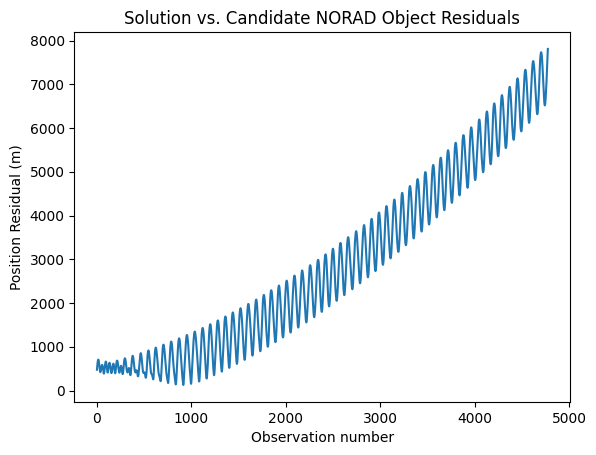

In [21]:
plt.plot(np.sqrt(solution_residuals(t, solve_sat.model, candidate_sat.model)) * 1000)
plt.title("Solution vs. Candidate NORAD Object Residuals")
plt.xlabel("Observation number")
plt.ylabel("Position Residual (m)")

## Calculate new TLE at same epoch as Reference / Truth TLE

* Grab the the epoch from the reference (truth) TLE
* Fit all ephemeris so epoch is in the sweet spot of the bathtub
    * This is probably bullshit, since we wouldn't have the future ephemeris yet
* Calculate the predicted state vector at the reference epoch using the fitted model
* add the predicted state vector to our ephemeris
* Re-fit up to the predicted state vector to get the mean elements for the reference epoch
* Compare fitted TLE to reference TLE

### Notes
* Probably better to interpolate ephemeris or use EKF to reference epoch

In [22]:
ref_tle = candidate_sat

In [23]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2021, 3, 4, 10, 59, 18, 94847, tzinfo=UTC)

In [24]:
ajd, ajdf = jday_datetime(sat_epoch_datetime(ref_tle.model))

In [25]:
# We'll do the thinning outside so we can preserve the new epoch

if obs_stride:
    tt = t[::obs_stride]
    et = ephemeris[::obs_stride]

if last_obs:
    tt = tt[:last_obs]
    et = et[:last_obs]

aligned_epoch_obs = np.searchsorted(tt, sat_epoch_datetime(ref_tle.model))
# ii = np.searchsorted(t, sat_epoch_datetime(ref_tle.model))
tt = np.insert(t, aligned_epoch_obs, sat_epoch_datetime(ref_tle.model))
et = ephemeris[:aligned_epoch_obs] + [tuple(np.array(x) for x in ref_tle.model.sgp4(ajd, ajdf)[1:])] + ephemeris[aligned_epoch_obs:] 

In [26]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2021, 3, 4, 10, 59, 18, 94847, tzinfo=UTC)

In [27]:
tt[aligned_epoch_obs]

datetime.datetime(2021, 3, 4, 10, 59, 18, 94847, tzinfo=UTC)

In [28]:
iterations, aligned_solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = test_tle_fit_normalized_equinoctial(tt, et, last_obs=None, obs_stride=None, epoch_obs=aligned_epoch_obs, lamda=1e-3, rms_epsilon=0.0001, debug=False)

In [29]:
aligned_solve_sat.model.intldesg = ref_tle.model.intldesg
# aligned_solve_sat.model.satnum = ref_tle.model.satnum # FIXME: assign this in satrec at creation
aligned_solve_sat.model.classification = ref_tle.model.classification
# aligned_solve_sat.model.ndot = ref_tle.model.ndot # Useless, but pretty
# aligned_solve_sat.model.nddot = ref_tle.model.nddot# Useless, but pretty

exporter.export_tle(aligned_solve_sat.model)

('1 99999U 14033K   21063.45784832  .00000000  00000-0  13843-3 0  9991',
 '2 99999  97.7289 244.3959 0082968 317.4242  42.0541 14.67086119    11')

In [30]:
exporter.export_tle(ref_tle.model)

('1 40019U 14033K   21063.45784832  .00000031  00000-0  13645-4 0  9995',
 '2 40019  97.7273 244.3980 0083219 317.6953  41.7853 14.67086494358887')

Text(0, 0.5, 'Position Residual (m)')

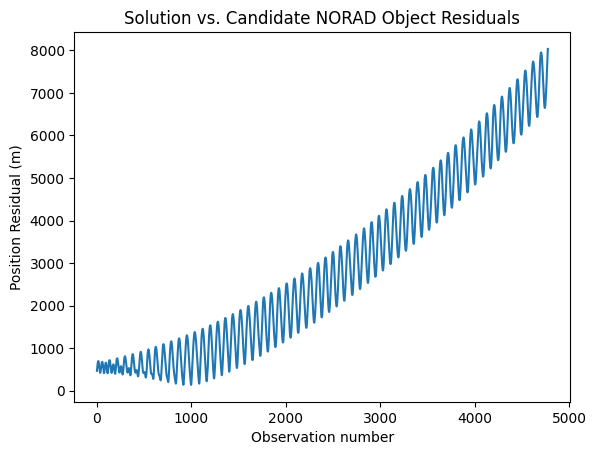

In [31]:
plt.plot(np.sqrt(solution_residuals(t, aligned_solve_sat.model, ref_tle.model)) * 1000)
plt.title("Solution vs. Candidate NORAD Object Residuals")
plt.xlabel("Observation number")
plt.ylabel("Position Residual (m)")